**Prédictions climatiques pour soutenir l'agriculture dans la région d'Hanoi**

Ce projet se concentre sur la construction d'un modèle de deep learning pour analyser et prédire des variables climatiques importantes, comme la température, afin de soutenir la prise de décision en agriculture. L'objectif est de fournir des prévisions précises basées sur des données historiques, permettant d'améliorer la gestion des ressources agricoles et d'anticiper les variations climatiques.

**Chargement des données**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Chemin du fichier contenant les données
file_path = '/content/drive/MyDrive/tempAsie/Hanoi_Vietnam.csv'

# Nom de la colonne cible à prédire
target_column = 'tmp'

# Chargement des données depuis le fichier CSV
# Pandas permet de lire facilement les fichiers CSV dans un DataFrame
data = pd.read_csv(file_path)

# Vérification que la colonne cible existe dans le fichier
# Si la colonne est absente, une erreur explicite est levée
if target_column not in data.columns:
    raise ValueError(f"Colonne {target_column} manquante dans les données.")

# Extraction des données de la colonne cible
# Suppression des éventuelles valeurs manquantes pour éviter les erreurs
series = data[target_column].dropna()

# Normalisation des données entre 0 et 1
# Les LSTM nécessitent des données normalisées pour un meilleur apprentissage
scaler = MinMaxScaler(feature_range=(0, 1))  # Plage de normalisation : [0, 1]
series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))  # Transformation de la série

# Confirmation du succès du chargement et de la normalisation
print("Données chargées et normalisées avec succès.")


Données chargées et normalisées avec succès.


**Création des séquences temporelles**

La première étape consiste à importer et préparer les données climatiques historiques nécessaires pour entraîner notre modèle. Cela inclut :

La vérification de la présence des colonnes essentielles, comme la température (tmp), qui est la variable cible.
Le traitement des valeurs manquantes pour garantir la qualité des données.
La normalisation des valeurs pour améliorer la performance et la stabilité du modèle lors de l'entraînement.

In [ ]:
# Fonction pour créer des séquences multi-étapes
def create_multi_step_sequences(data, sequence_length, forecast_steps):
    """
    Génère des séquences de données temporelles pour entraîner un modèle LSTM.

    data : np.array
        Série temporelle normalisée.
    sequence_length : int
        Longueur de chaque séquence (nombre de points dans l'historique).
    forecast_steps : int
        Nombre d'étapes futures que le modèle doit prédire.

    Retourne :
    - X : np.array, les séquences d'entrée (historique des données).
    - y : np.array, les séquences cibles (valeurs futures à prédire).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_steps + 1):
        # Ajouter la séquence de données historiques dans X
        X.append(data[i:i + sequence_length])
        # Ajouter les valeurs futures correspondantes dans y
        y.append(data[i + sequence_length:i + sequence_length + forecast_steps])
    return np.array(X), np.array(y)

# Définir la longueur des séquences d'entrée et le nombre d'étapes de prévision
sequence_length = 20  # Nombre de points historiques à utiliser pour chaque séquence
forecast_steps = 5  # Nombre d'étapes futures à prévoir

# Créer les séquences à partir des données normalisées
# Cela prépare les données pour être utilisées par le modèle LSTM
X, y = create_multi_step_sequences(series_scaled, sequence_length, forecast_steps)

# Division des données en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)  # Utiliser 80% des données pour l'entraînement
X_train, X_test = X[:train_size], X[train_size:]  # Séquences d'entraînement et de test
y_train, y_test = y[:train_size], y[train_size:]  # Cibles d'entraînement et de test

# Afficher les dimensions des ensembles créés pour validation
print(f"Ensembles d'entraînement et de test créés :")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")


Ensembles d'entraînement et de test créés :
X_train : (1152, 20, 1), y_train : (1152, 5, 1)
X_test : (288, 20, 1), y_test : (288, 5, 1)


**Construction du modèle LSTM**

Cette étape consiste à créer un modèle basé sur les réseaux de neurones LSTM (Long Short-Term Memory), une architecture de deep learning particulièrement adaptée à l'analyse des séries temporelles. Les LSTM sont conçus pour capturer les dépendances temporelles et les motifs dans les données historiques, ce qui les rend idéaux pour des tâches de prévision sur des séquences.

Dans ce projet, le modèle est construit avec plusieurs couches LSTM pour capturer des motifs complexes, suivies de couches de régularisation (Dropout) pour éviter le sur-apprentissage. Enfin, une couche dense permet de produire les prédictions pour les étapes futures.

In [ ]:
from tensorflow.keras.optimizers import Adam

# Définition du modèle LSTM
model = Sequential([
    # Première couche LSTM avec recurrent_dropout pour mieux régulariser les connexions récurrentes
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.2),
    Dropout(0.3),

    # Deuxième couche LSTM avec moins d'unités et également un recurrent_dropout
    LSTM(64, recurrent_dropout=0.2),
    Dropout(0.2),

    # Couche Dense finale
    Dense(forecast_steps)
])

# Compilation avec un learning_rate personnalisé
optimizer = Adam(learning_rate=0.001)  # On ajuste le learning rate pour la stabilité
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Affichage du résumé du modèle
model.summary()


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_79 (LSTM)                       │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_80 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,293 (454.27 KB)

 Trainable params: 116,293 (454.27 KB)

 Non-trainable params: 0 (0.00 B)

**Entraînement du modèle**

L'entraînement du modèle consiste à lui apprendre à faire des prédictions précises en utilisant les données d'entraînement. Durant cette étape, le modèle ajuste ses paramètres internes (poids et biais) pour minimiser la différence entre les prédictions et les valeurs réelles.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Définition du callback EarlyStopping
# - Monitor : 'val_loss' pour surveiller la perte sur l'ensemble de validation.
# - Patience : Nombre d'époques sans amélioration avant d'arrêter (ici, 10).
# - restore_best_weights : Assure que les meilleurs poids sont restaurés à la fin.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle
# - X_train et y_train : Données d'entraînement pour ajuster les poids.
# - validation_data : Données de validation pour évaluer le modèle après chaque époque.
# - epochs : Nombre maximum d'époques pour entraîner le modèle.
# - batch_size : Taille des lots pour l'entraînement. Les données sont divisées en petits groupes (batches) pour accélérer l'apprentissage.
# - callbacks : Utilisation de `EarlyStopping` pour éviter un sur-apprentissage et optimiser l'entraînement.
# - verbose=1 : Affiche les détails de l'entraînement pour suivre la progression.
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # Ensemble de validation
    epochs=50,  # Nombre maximum d'époques
    batch_size=64,  # Taille des lots
    callbacks=[early_stopping],  # Stoppe si pas d'amélioration
    verbose=1  # Affiche les logs
)

# Confirmation que l'entraînement est terminé
print("Entraînement terminé.")


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.2578 - mae: 0.4244 - val_loss: 0.0859 - val_mae: 0.2588
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0938 - mae: 0.2644 - val_loss: 0.0747 - val_mae: 0.2416
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0829 - mae: 0.2510 - val_loss: 0.0660 - val_mae: 0.2284
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0720 - mae: 0.2325 - val_loss: 0.0290 - val_mae: 0.1455
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0392 - mae: 0.1596 - val_loss: 0.0090 - val_mae: 0.0762
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0221 - mae: 0.1173 - val_loss: 0.0084 - val_mae: 0.0722
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.0206 - mae: 0.1146 - val_loss: 0.0061 - val_mae: 0.0620
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0181 - mae: 0.1065 - val_loss: 0.0069 - val_mae: 0.0658
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.01

**courbes d'apprentissage**

Les courbes d'apprentissage permettent de visualiser l'évolution de la perte (loss) et des métriques (comme la Mean Absolute Error, MAE) pendant l'entraînement du modèle. Ces courbes sont essentielles pour évaluer si le modèle converge correctement, s'il sur-apprend (overfitting) ou sous-apprend (underfitting).

Perte d'entraînement (loss) : Montre à quel point le modèle s'adapte aux données d'entraînement.
Perte de validation (val_loss) : Évalue les performances du modèle sur des données qu'il n'a jamais vues pendant l'entraînement.
Une courbe bien équilibrée montre une diminution progressive des deux pertes avec une stabilisation à un niveau bas.
Ces visualisations permettent aussi de détecter :

Un sur-apprentissage, lorsque la perte d'entraînement diminue mais que la perte de validation augmente.
Un sous-apprentissage, lorsque les deux pertes restent élevées.

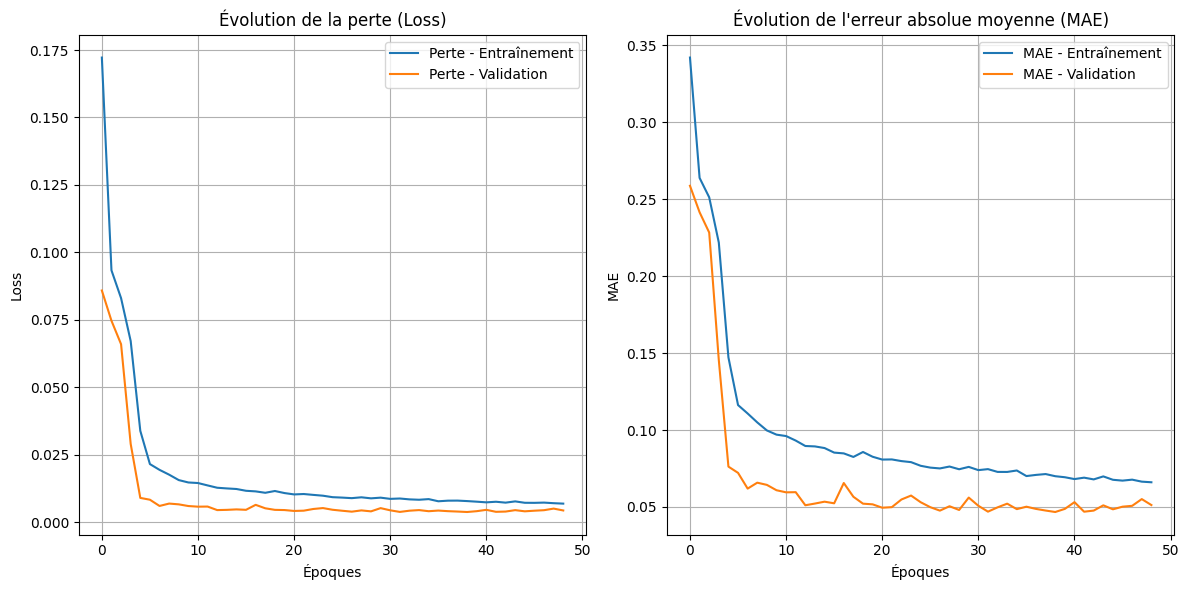

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'apprentissage
plt.figure(figsize=(12, 6))

# Courbe de la perte (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte - Entraînement')
plt.plot(history.history['val_loss'], label='Perte - Validation')
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Courbe de l'erreur absolue moyenne (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE - Entraînement')
plt.plot(history.history['val_mae'], label='MAE - Validation')
plt.title("Évolution de l'erreur absolue moyenne (MAE)")
plt.xlabel("Époques")
plt.ylabel("MAE")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


**Évaluation du modèle**

L’évaluation du modèle est une étape cruciale pour mesurer ses performances et vérifier sa capacité à généraliser sur des données qu’il n’a jamais vues. Cela inclut le calcul de métriques clés et la visualisation des résultats pour interpréter les prédictions.

Les principales métriques utilisées ici sont :

Mean Squared Error (MSE) : Une mesure des erreurs au carré, mettant davantage l'accent sur les grandes erreurs. Une valeur basse indique un bon ajustement.
Mean Absolute Error (MAE) : Mesure intuitive de l'erreur moyenne absolue. Plus elle est basse, mieux c’est.
Coefficient de détermination (R²) : Indique dans quelle mesure le modèle explique la variance des données. Une valeur proche de 1 montre un modèle performant.
En plus des métriques, des visualisations sont créées pour comparer les prédictions et les valeurs réelles. Cela permet de détecter visuellement les tendances bien capturées et les écarts éventuels.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Erreur quadratique moyenne (MSE) : 1.0949
Erreur absolue moyenne (MAE) : 0.7904
Coefficient de détermination (R²) : 0.9481


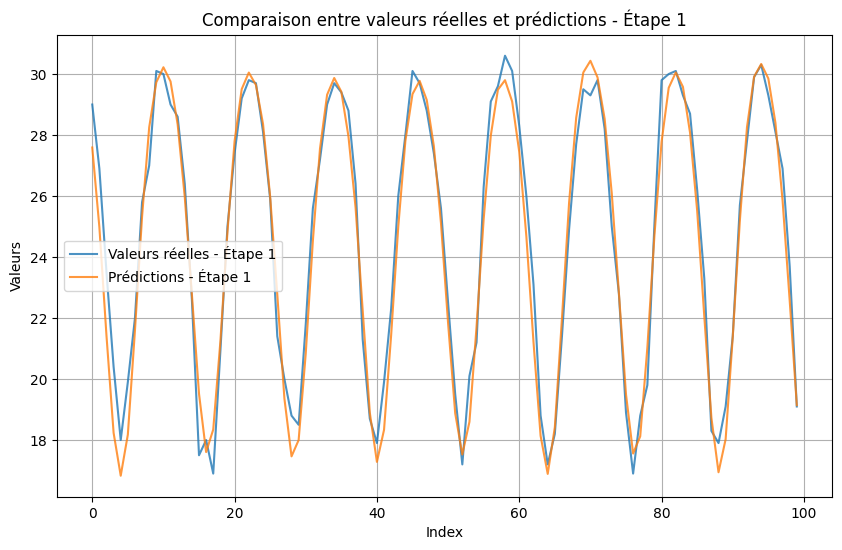

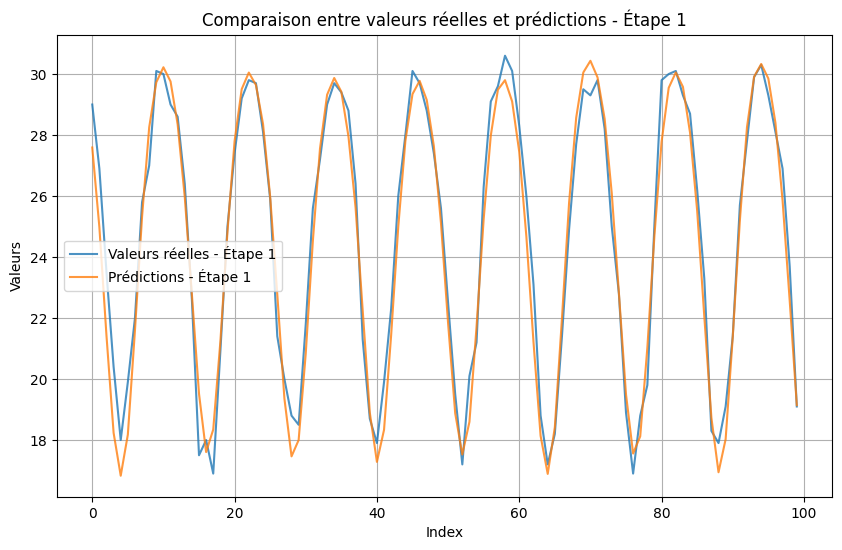

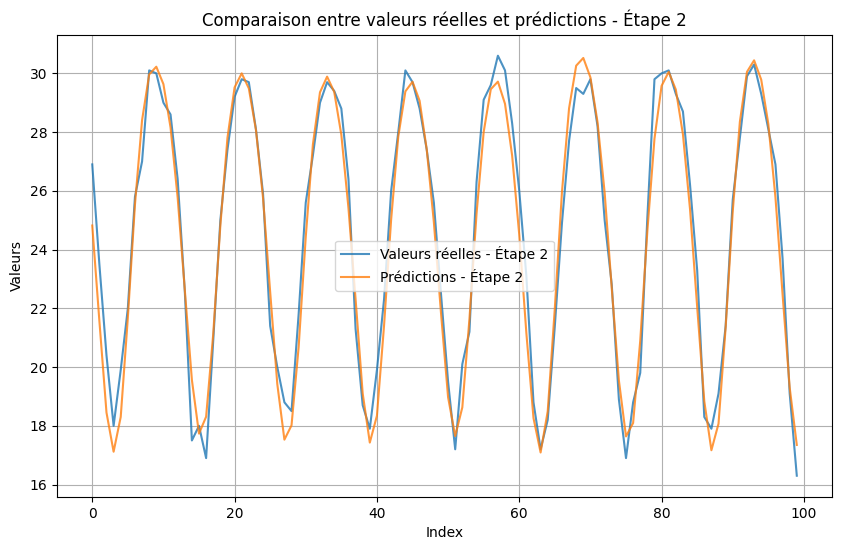

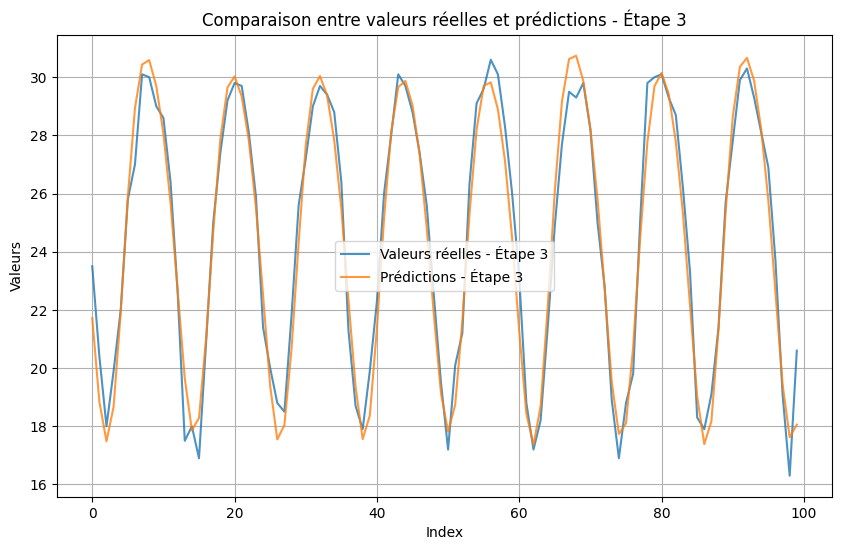

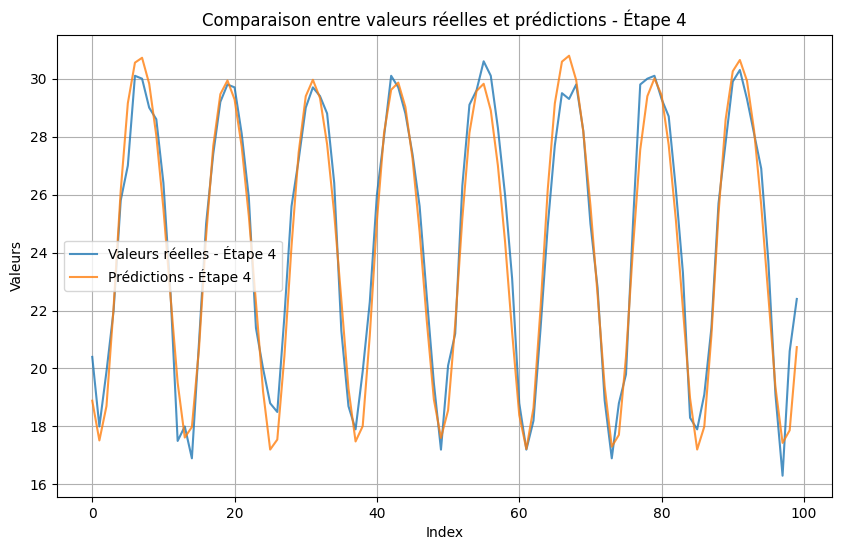

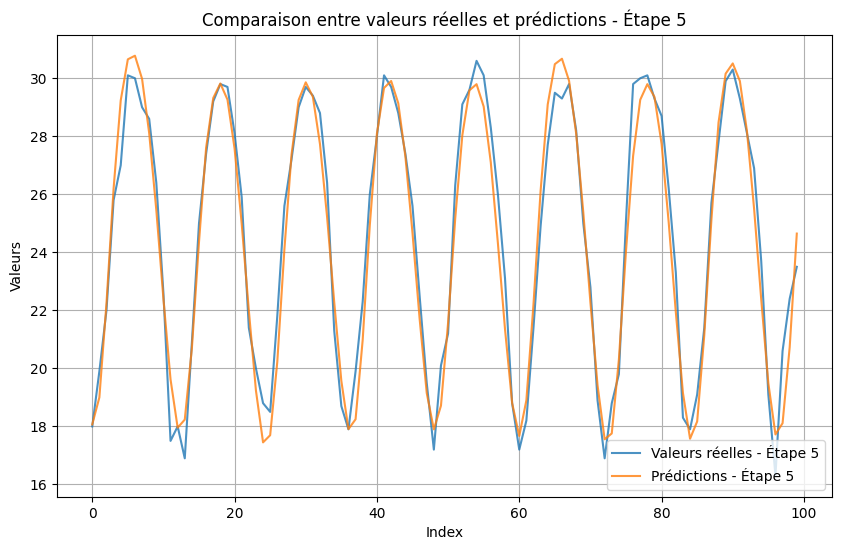

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prédictions sur l'ensemble de test
# Le modèle utilise les données de test pour générer les prédictions
y_pred = model.predict(X_test)

# Inverser la normalisation pour ramener les données à leur échelle d'origine
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Calcul des métriques d'évaluation
mse = mean_squared_error(y_test_original[:, 0], y_pred_original[:, 0])  # Erreur quadratique moyenne
mae = mean_absolute_error(y_test_original[:, 0], y_pred_original[:, 0])  # Erreur absolue moyenne
r2 = r2_score(y_test_original[:, 0], y_pred_original[:, 0])  # Coefficient de détermination

# Affichage des résultats des métriques
print("=" * 50)
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")
print(f"Erreur absolue moyenne (MAE) : {mae:.4f}")
print(f"Coefficient de détermination (R²) : {r2:.4f}")
print("=" * 50)

# Visualisation des prédictions pour la première étape de prévision
# Affiche les 100 premières valeurs réelles et prédites
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100, 0], label="Valeurs réelles - Étape 1", alpha=0.8)
plt.plot(y_pred_original[:100, 0], label="Prédictions - Étape 1", alpha=0.8)
plt.title("Comparaison entre valeurs réelles et prédictions - Étape 1")
plt.xlabel("Index")
plt.ylabel("Valeurs")
plt.legend()
plt.grid()
plt.show()

# Visualisation des prédictions pour chaque étape de prévision
# Affiche les prédictions pour les différentes étapes de prévision
for step in range(forecast_steps):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original[:100, step], label=f"Valeurs réelles - Étape {step + 1}", alpha=0.8)
    plt.plot(y_pred_original[:100, step], label=f"Prédictions - Étape {step + 1}", alpha=0.8)
    plt.title(f"Comparaison entre valeurs réelles et prédictions - Étape {step + 1}")
    plt.xlabel("Index")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid()
    plt.show()


**Distribution des erreurs**

Cette étape analyse les erreurs, calculées comme la différence entre les valeurs réelles et les prédictions du modèle.

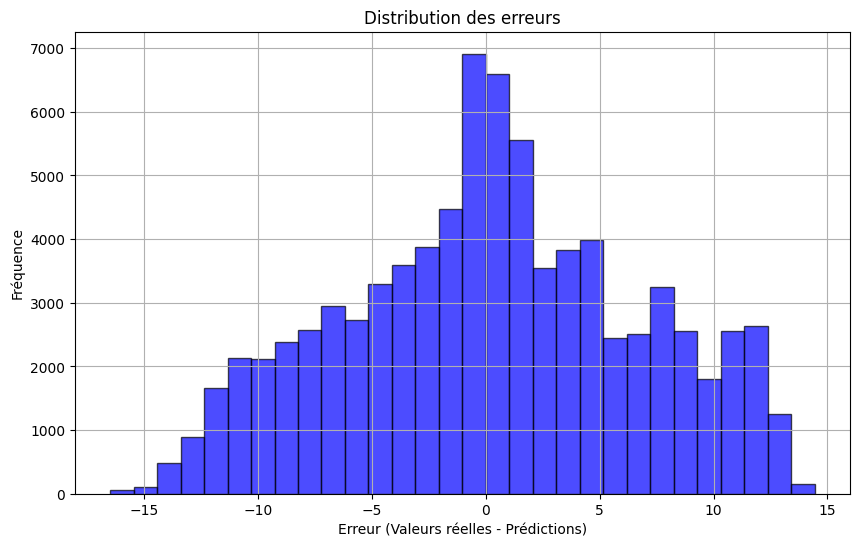

In [ ]:
# Calcul des erreurs
# Soustraction entre les valeurs réelles (y_test_original) et les prédictions (y_pred_original) pour la première étape.
# La méthode flatten() garantit que les erreurs sont converties en une liste 1D pour l'analyse.
errors = (y_test_original[:, 0] - y_pred_original[:, 0]).flatten()

# Histogramme des erreurs
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution des erreurs")
plt.xlabel("Erreur (Valeurs réelles - Prédictions)")
plt.ylabel("Fréquence")
plt.grid()
plt.show()


**Importance des étapes de prévision**

L'objectif ici est de mesurer et visualiser comment les performances du modèle évoluent à chaque étape de prévision. Les étapes plus proches (à court terme) sont généralement plus précises que celles à long terme, car les erreurs s'accumulent avec le temps.

Nous utilisons des métriques comme MSE (Mean Squared Error) et MAE (Mean Absolute Error) pour évaluer la précision à chaque étape de prévision. Ces métriques permettent de comprendre à quel point le modèle est fiable pour des horizons différents.

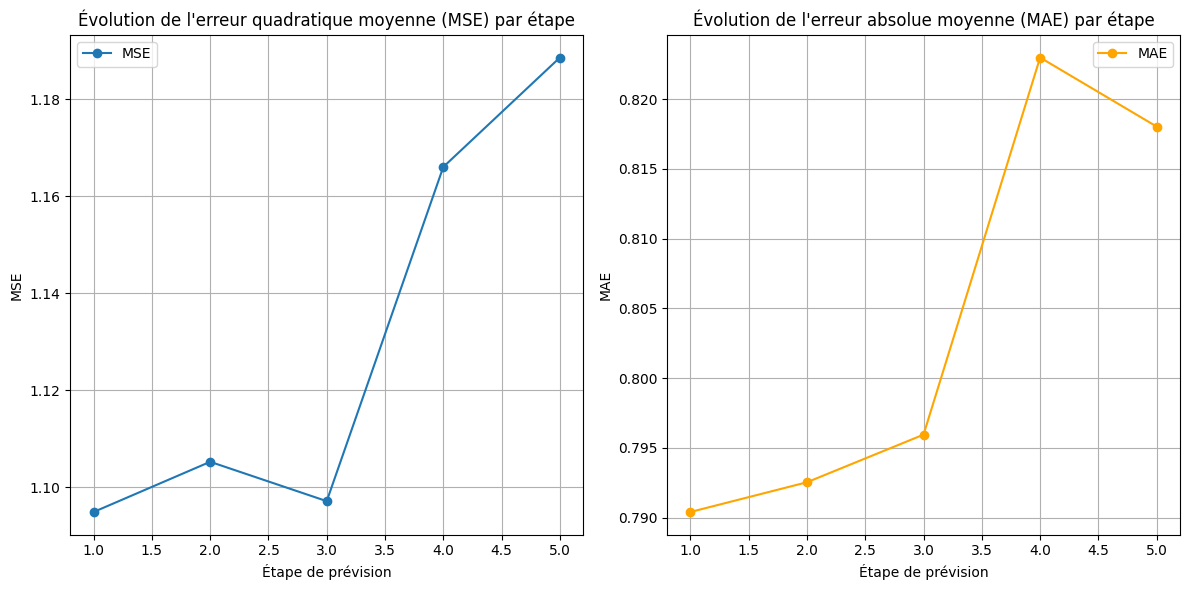

In [ ]:
# Calcul des métriques pour chaque étape de prévision
mse_per_step = []
mae_per_step = []

for step in range(forecast_steps):
    mse_per_step.append(mean_squared_error(y_test_original[:, step], y_pred_original[:, step]))
    mae_per_step.append(mean_absolute_error(y_test_original[:, step], y_pred_original[:, step]))

# Visualisation des métriques par étape
plt.figure(figsize=(12, 6))

# Graphique pour MSE
plt.subplot(1, 2, 1)
plt.plot(range(1, forecast_steps + 1), mse_per_step, marker='o', label="MSE")
plt.title("Évolution de l'erreur quadratique moyenne (MSE) par étape")
plt.xlabel("Étape de prévision")
plt.ylabel("MSE")
plt.grid()
plt.legend()

# Graphique pour MAE
plt.subplot(1, 2, 2)
plt.plot(range(1, forecast_steps + 1), mae_per_step, marker='o', label="MAE", color='orange')
plt.title("Évolution de l'erreur absolue moyenne (MAE) par étape")
plt.xlabel("Étape de prévision")
plt.ylabel("MAE")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


**Graphes de dispersion (valeurs réelles vs prédictions)**

Les graphes de dispersion permettent de visualiser la relation entre les valeurs réelles et les prédictions du modèle pour chaque étape de prévision.

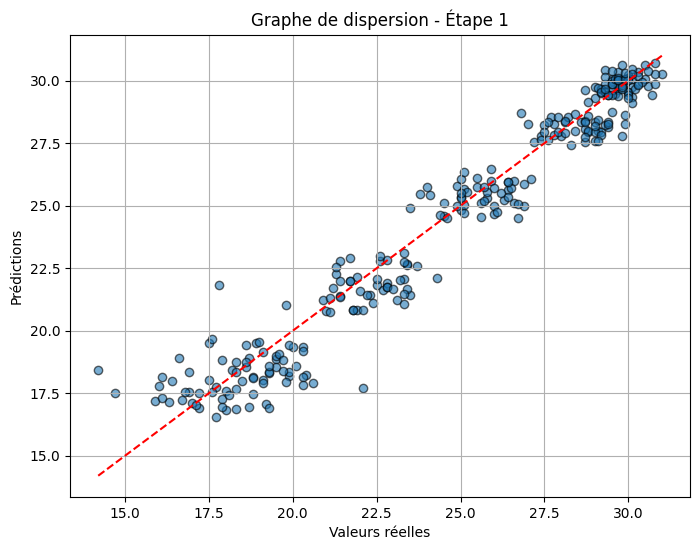

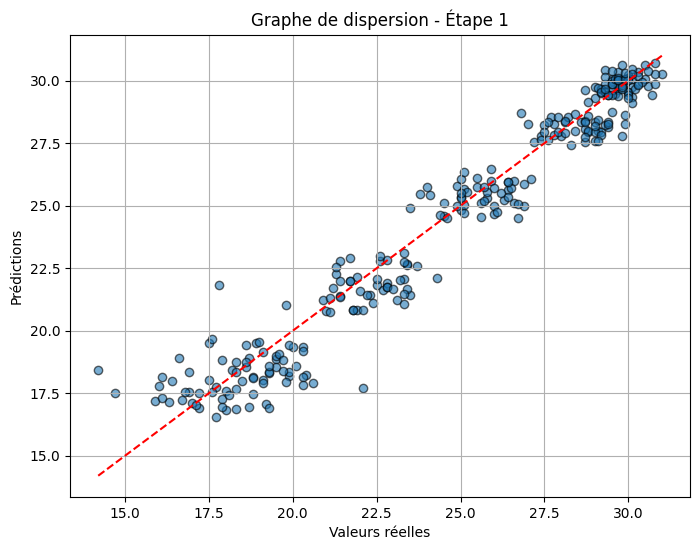

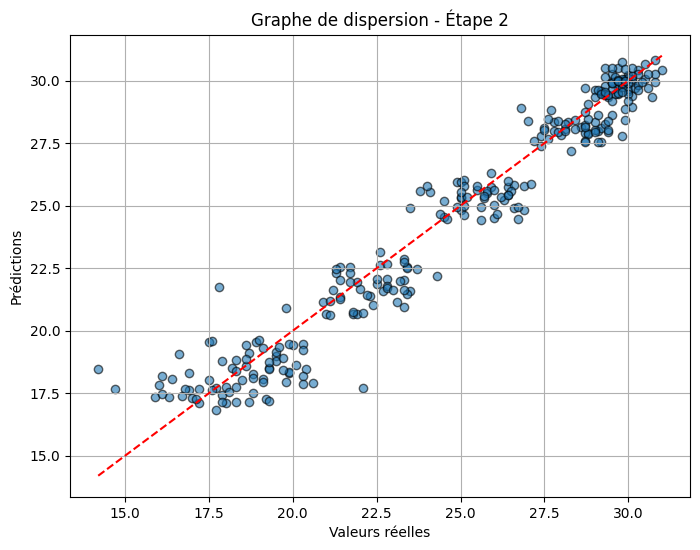

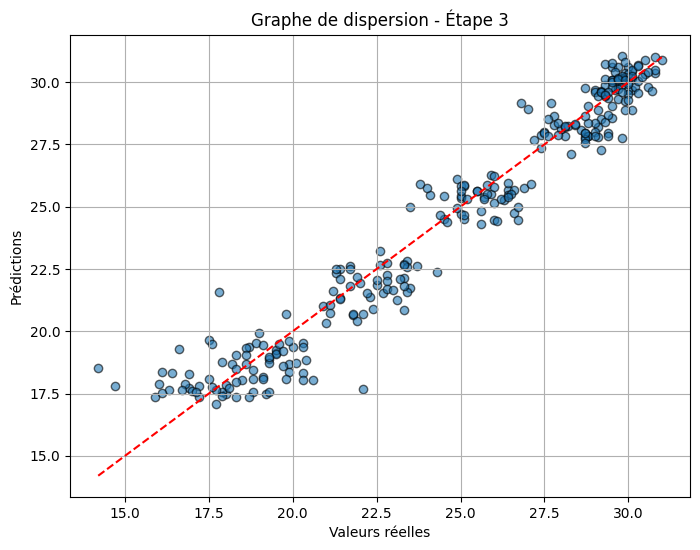

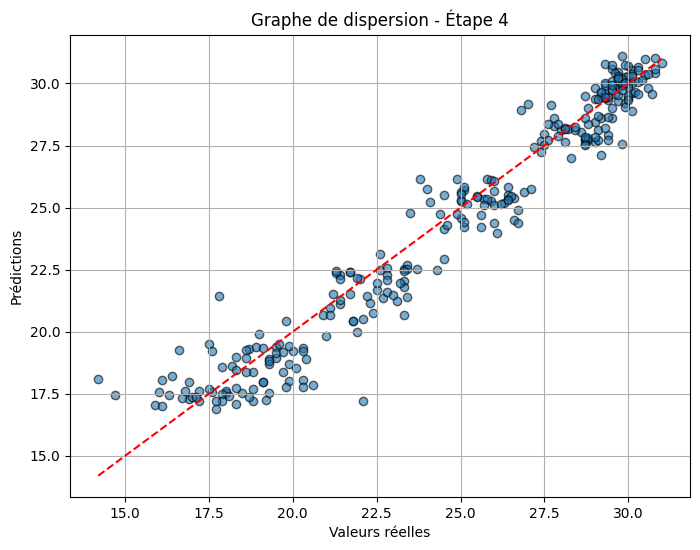

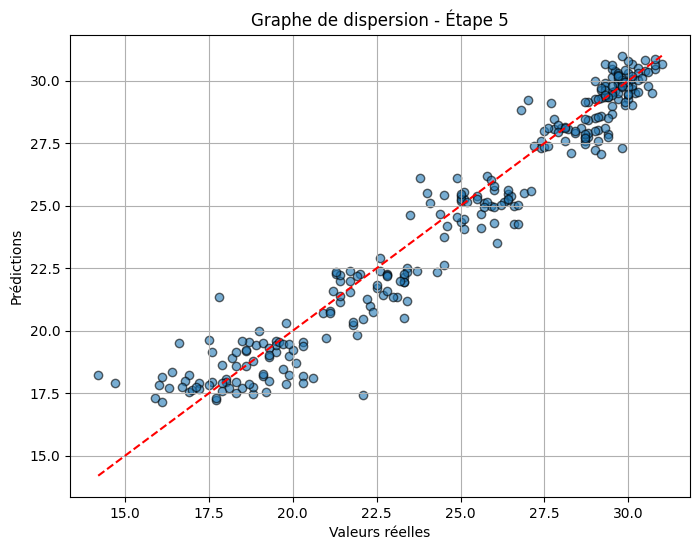

In [ ]:
# Graphe de dispersion pour la première étape de prévision
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original[:, 0], y_pred_original[:, 0], alpha=0.6, edgecolor='k')
plt.title("Graphe de dispersion - Étape 1")
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], color='red', linestyle='--')
plt.grid()
plt.show()

# Graphe de dispersion pour chaque étape
for step in range(forecast_steps):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original[:, step], y_pred_original[:, step], alpha=0.6, edgecolor='k')
    plt.title(f"Graphe de dispersion - Étape {step + 1}")
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.plot([y_test_original.min(), y_test_original.max()],
             [y_test_original.min(), y_test_original.max()], color='red', linestyle='--')
    plt.grid()
    plt.show()
